#### 27.11.2023 Artush Mkrtchyan

## CA 2


### Task 1


#### Importing neccessary libraries:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored, integrated_brier_score

from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test, proportional_hazard_test

In [2]:
colon_data = pd.read_csv("colon.csv")

colon_data.head()

,Unnamed: 0,id,study,rx,sex,age,obstruct,perfor,adhere,nodes,status,differ,extent,surg,node4,time,etype
0,1,1,1,Lev+5FU,1,43,0,0,0,5.0,1,2.0,3,0,1,1521,2
1,2,1,1,Lev+5FU,1,43,0,0,0,5.0,1,2.0,3,0,1,968,1
2,3,2,1,Lev+5FU,1,63,0,0,0,1.0,0,2.0,3,0,0,3087,2
3,4,2,1,Lev+5FU,1,63,0,0,0,1.0,0,2.0,3,0,0,3087,1
4,5,3,1,Obs,0,71,0,0,1,7.0,1,2.0,2,0,1,963,2


In [3]:
# Calculate the 34th and 67th percentiles of age for the entire dataset
age_34th_percentile = np.percentile(colon_data['age'], 34)
age_67th_percentile = np.percentile(colon_data['age'], 67)

# Splitting the age into three groups for the entire dataset
colon_data['age_group'] = pd.cut(colon_data['age'], 
                           bins=[colon_data['age'].min()-1, age_34th_percentile, age_67th_percentile, colon_data['age'].max()],
                           labels=['Young', 'Middle', 'Old'])


colon_data['age_group'] = colon_data['age_group'].astype('category')
colon_data['differ'] = colon_data['differ'].fillna(2)
colon_data['differ'] = colon_data['differ'].astype('int64')

In [4]:
# Function for plotting Kaplan-Meier curves
def plot_km_curve(df, covariate, title):

    # Check if covariate is categorical, if not, convert it
    if not pd.api.types.is_categorical_dtype(df[covariate]):
        df[covariate] = df[covariate].astype('category')

    # Creating a new figure for each plot    
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)

    kmf_fitters = []

    for category in df[covariate].cat.categories:
        mask = df[covariate] == category
        kmf = KaplanMeierFitter()

         # Assign color based on category value
        if covariate in ['sex', 'obstruct', 'perfor', 'adhere', 'surg', 'node4'] and category in [0, 'Obs']:
            color = 'orange'
        elif covariate == 'rx':
            color = {'Obs': 'orange', 'Lev': 'blue', 'Lev+5FU':'green'}.get(category, 'blue')
        elif covariate == 'differ': 
            color = {1: 'green', 2: 'blue', 3: 'orange'}.get(category, 'blue')
        elif covariate == 'extent':
            color = {1: 'green', 2: 'blue', 3: 'orange', 4: 'red'}.get(category, 'blue')
        elif covariate == 'age_group':
            color = {'Young': 'green', 'Middle': 'blue', 'Old': 'orange'}.get(category, 'blue')
        else:
            color = 'blue'  # Default color


        # Plotting the Kaplan-Meier curves with censors
        
        kmf.fit(durations=df[mask]['time'], event_observed=df[mask]['status'], label=str(category))
        kmf.plot_survival_function(ax=ax, show_censors=True, color=color)

        # Store the fitted kmf object for later use
        kmf_fitters.append(kmf)

    # Add at-risk counts for all groups
    add_at_risk_counts(*kmf_fitters, ax=ax)

    plt.title(title)
    plt.xlabel('Days')
    plt.ylabel('Survival Probability')
    plt.show()

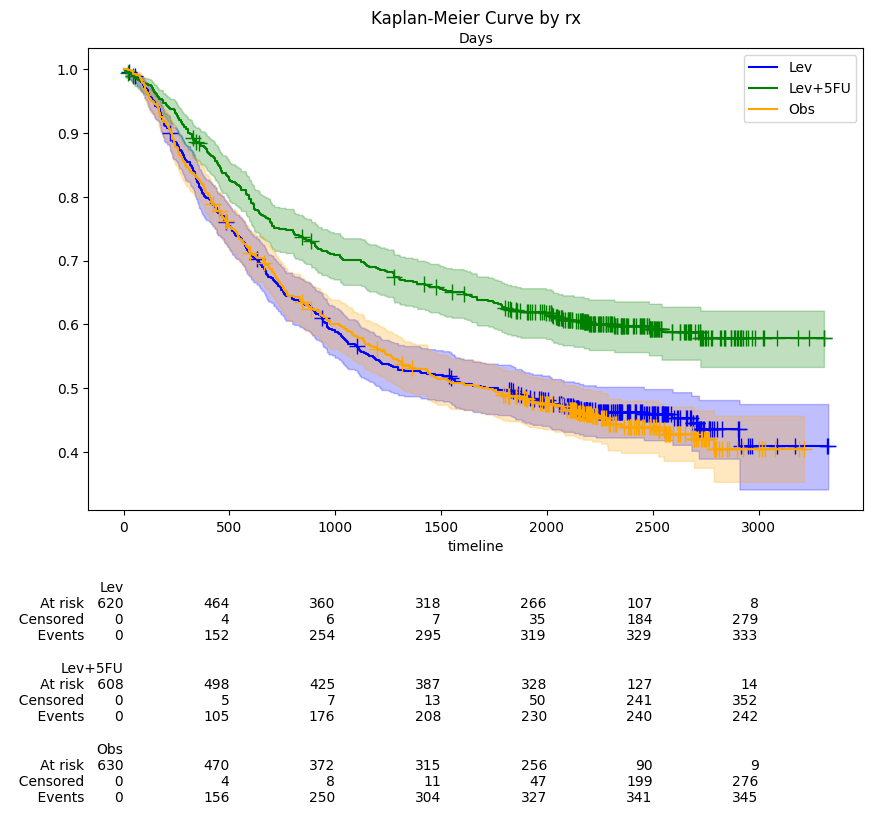

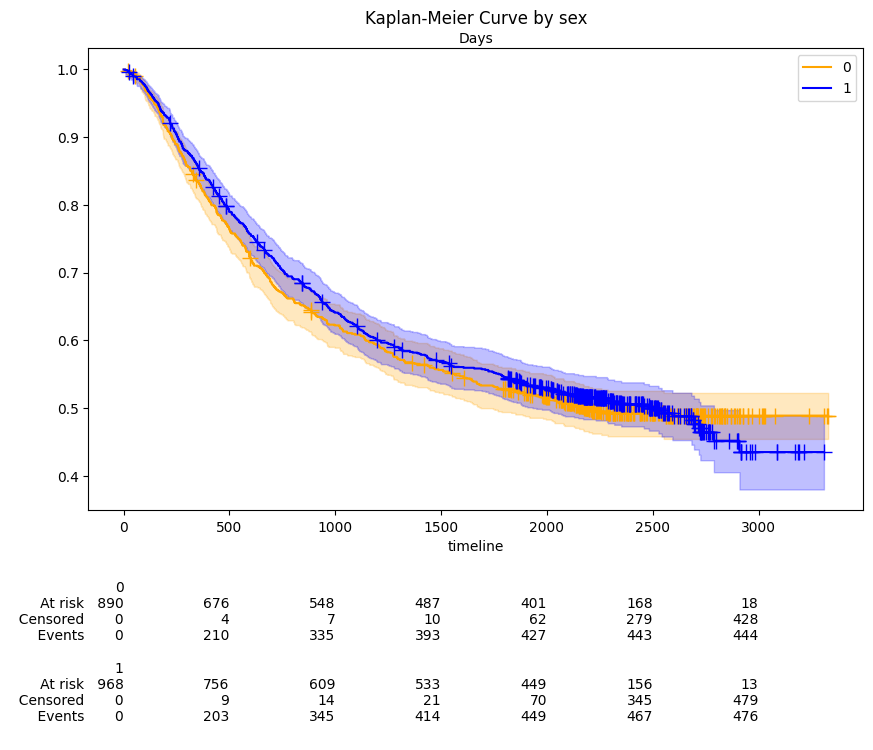

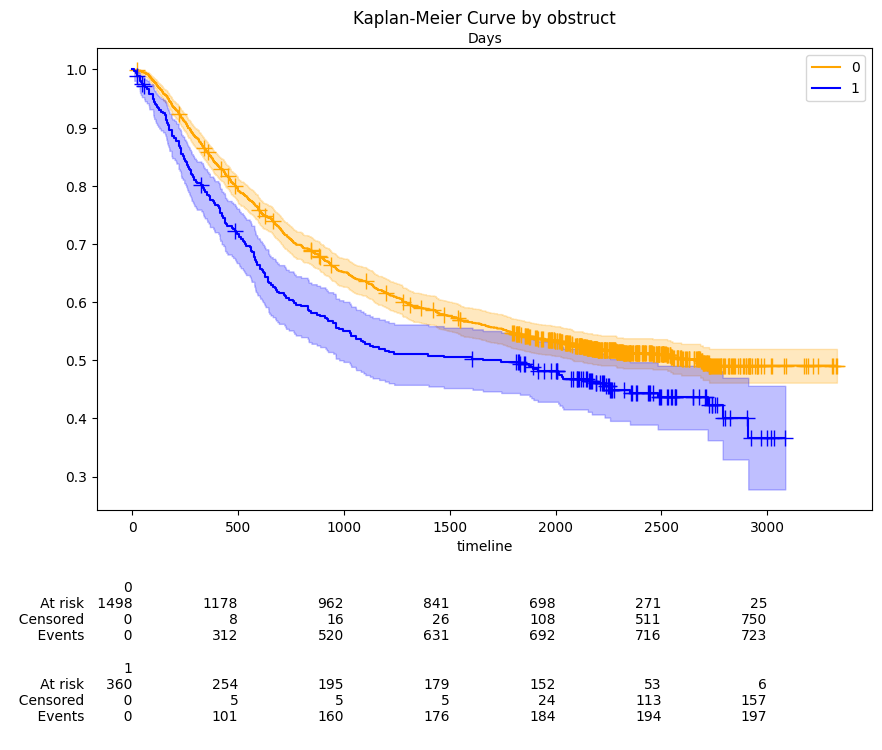

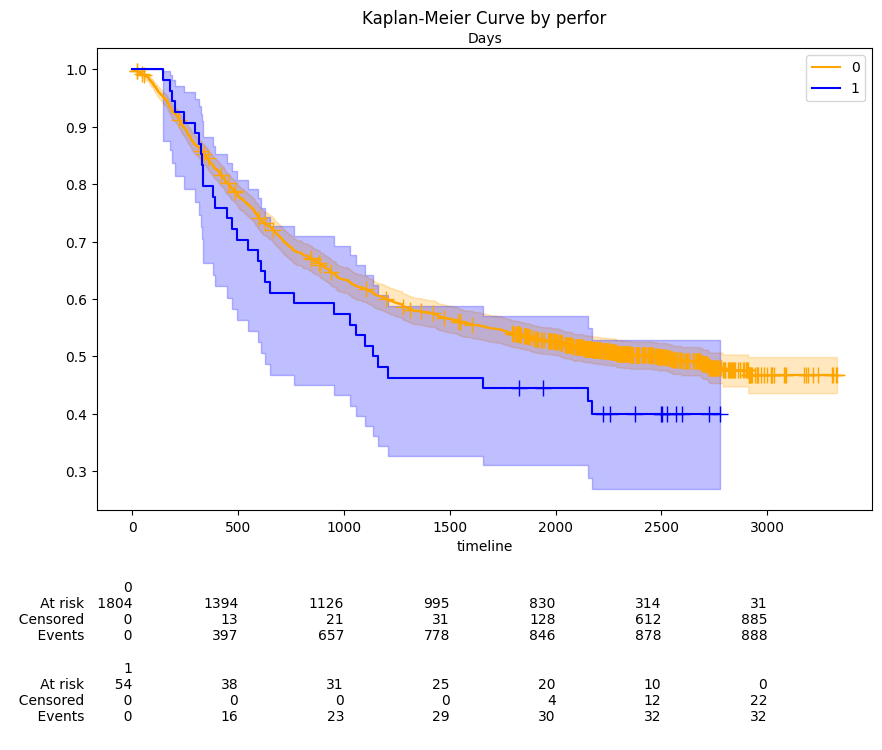

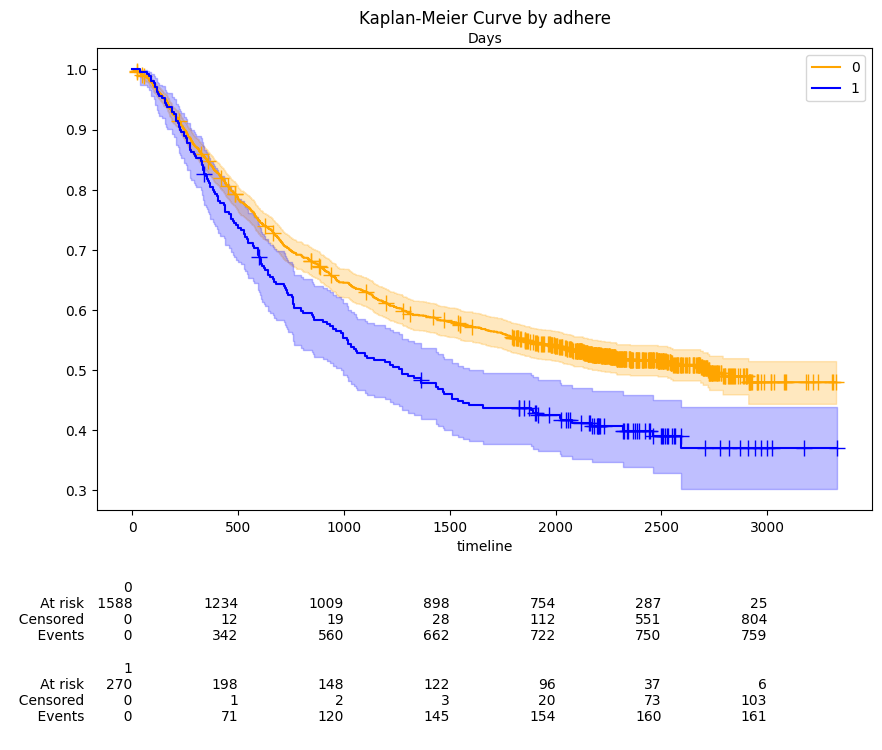

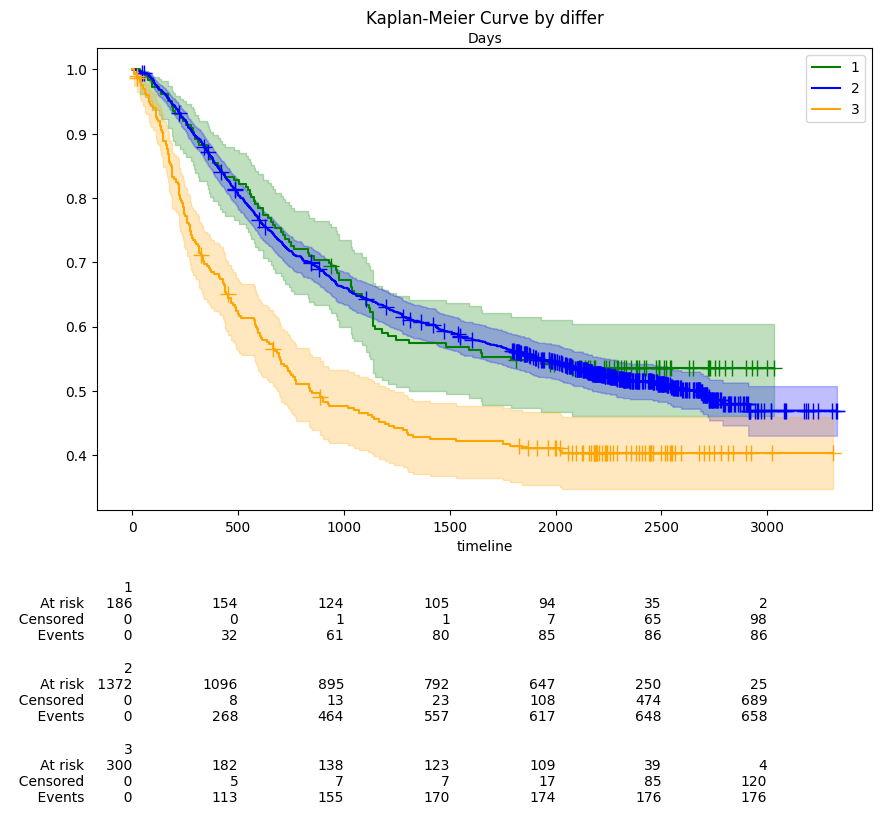

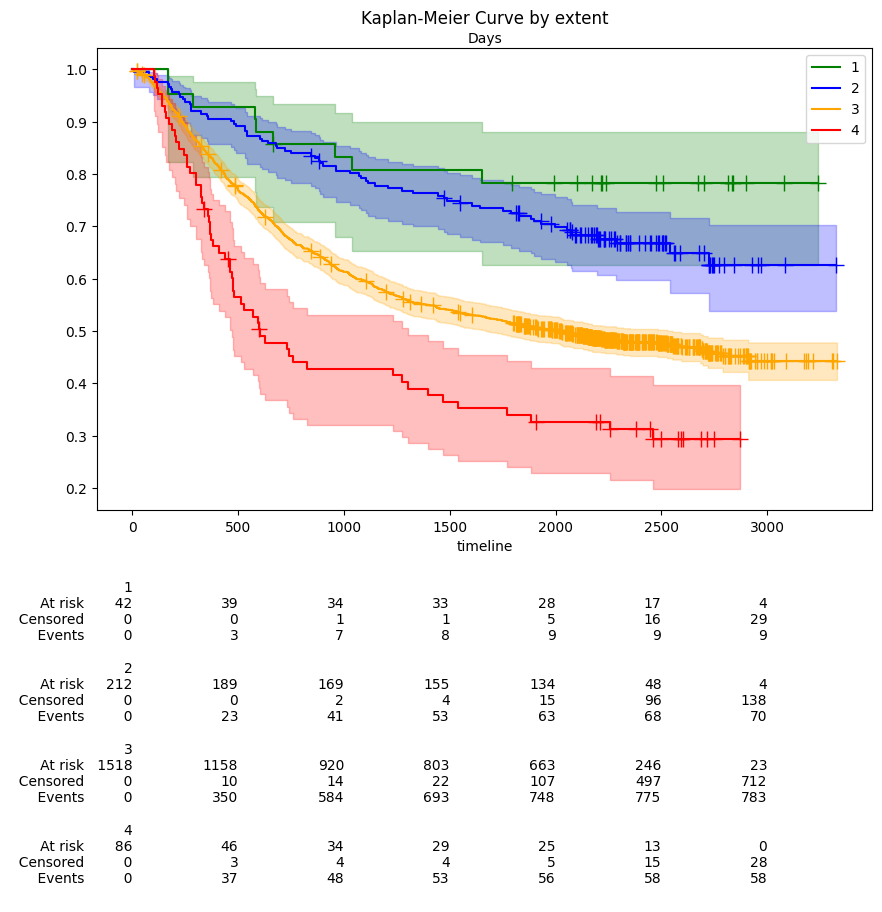

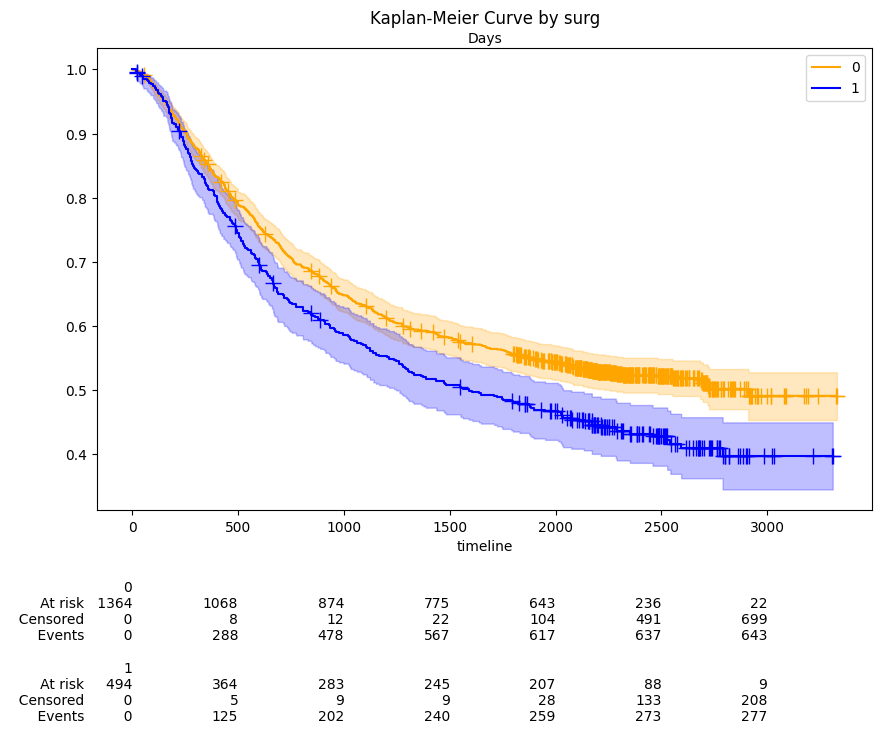

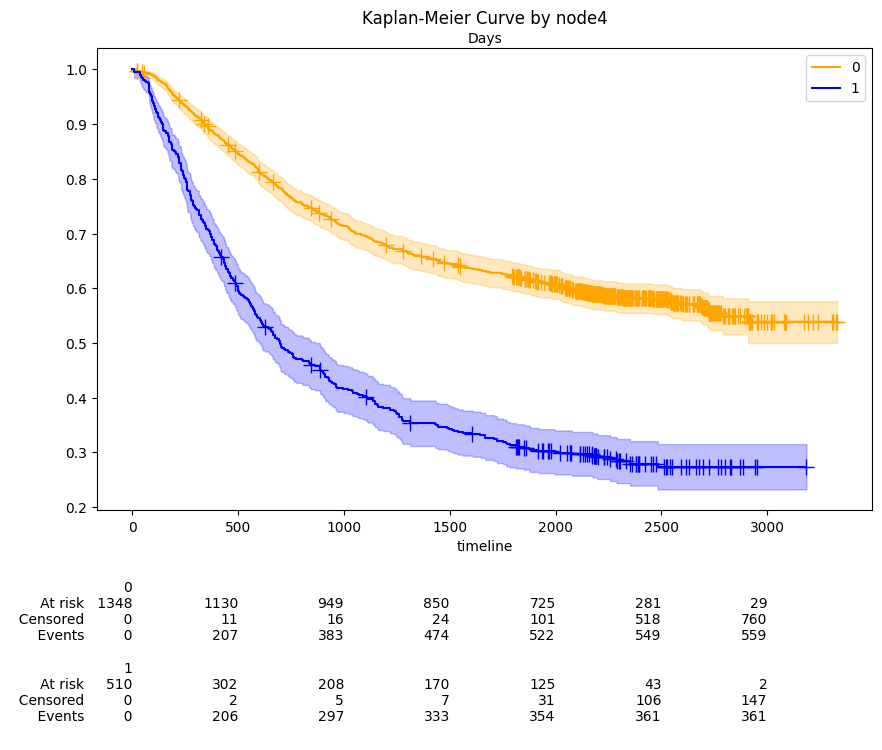

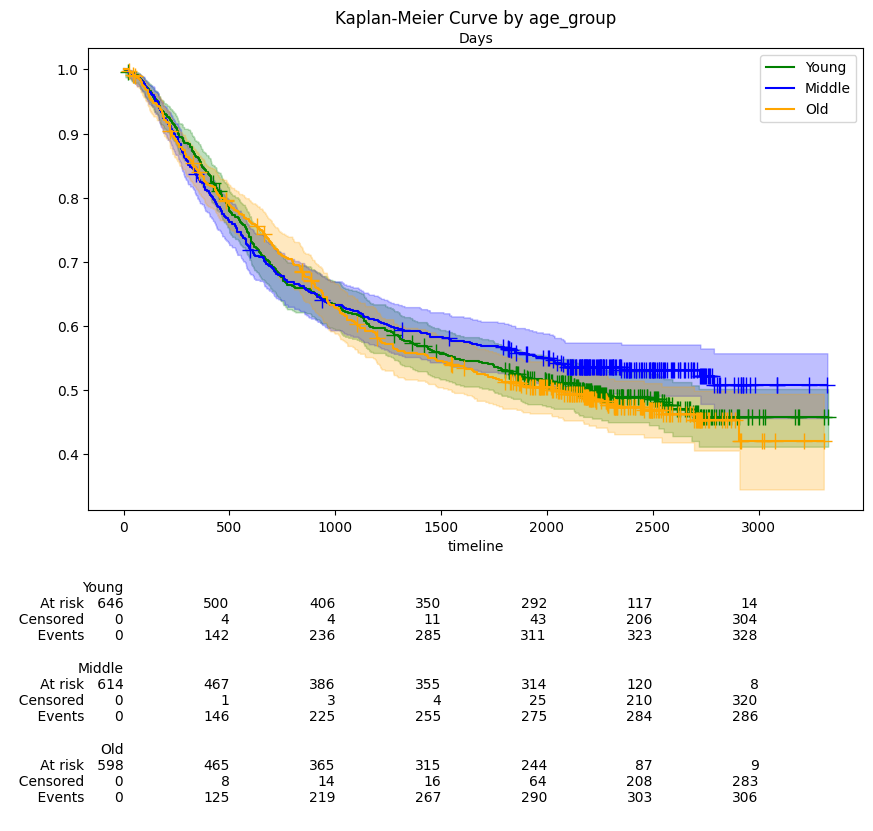

In [5]:
# Plotting Kaplan-Meier curves for each covariate, including both events and censored data
covariates = ['rx', 'sex', 'obstruct', 'perfor', 'adhere', 'differ', 'extent', 'surg', 'node4', 'age_group']
for covariate in covariates:
    plot_km_curve(colon_data, covariate, f"Kaplan-Meier Curve by {covariate}")


In [6]:
# Function to perform log-rank tests between groups of a covariate
def perform_logrank_tests(df, covariate):
    categories = df[covariate].unique()
    logrank_results = {}
    for i in range(len(categories)):
        for j in range(i+1, len(categories)):
            group1 = df[df[covariate] == categories[i]]
            group2 = df[df[covariate] == categories[j]]
            result = logrank_test(group1['time'], group2['time'], group1['status'], group2['status'])
            logrank_results[f"{categories[i]} vs {categories[j]}"] = result.p_value
    return logrank_results

# List of covariates to test, excluding 'age_group'
covariates_to_test = ['rx', 'sex', 'obstruct', 'perfor', 'adhere', 'surg', 'node4']

# Perform log-rank tests for each covariate and aggregate results
all_logrank_results = {}
for covariate in covariates_to_test:
    all_logrank_results[covariate] = perform_logrank_tests(colon_data, covariate)

# Display the aggregated log-rank test results
all_logrank_results


{'rx': {'Lev+5FU vs Obs': 1.0958640021388373e-07,
  'Lev+5FU vs Lev': 6.302887087573739e-07,
  'Obs vs Lev': 0.7842255176231738},
 'sex': {'1 vs 0': 0.6107936361225195},
 'obstruct': {'0 vs 1': 0.0025425224580773276},
 'perfor': {'0 vs 1': 0.14056368623551893},
 'adhere': {'0 vs 1': 0.00026707684914530105},
 'surg': {'0 vs 1': 0.0005913082600358052},
 'node4': {'1 vs 0': 3.007449244024733e-43}}

In [7]:
# Perform log-rank tests for age groups
young = colon_data[colon_data['age_group'] == 'Young']
middle = colon_data[colon_data['age_group'] == 'Middle']
old = colon_data[colon_data['age_group'] == 'Old']

logrank_young_middle = logrank_test(young['time'], middle['time'], young['status'], middle['status'])
logrank_young_old = logrank_test(young['time'], old['time'], young['status'], old['status'])
logrank_middle_old = logrank_test(middle['time'], old['time'], middle['status'], old['status'])

age_logrank_results = {
    "Young vs Middle": logrank_young_middle.p_value,
    "Young vs Old": logrank_young_old.p_value,
    "Middle vs Old": logrank_middle_old.p_value
}

age_logrank_results

{'Young vs Middle': 0.2736323531478856,
 'Young vs Old': 0.7289217062797975,
 'Middle vs Old': 0.1570088715893579}

In [8]:
# Perform log-rank tests for differ

differ1 = colon_data[colon_data['differ'] == 1]
differ2 = colon_data[colon_data['differ'] == 2]
differ3 = colon_data[colon_data['differ'] == 3]

logrank_differ1_differ2 = logrank_test(differ1['time'], differ2['time'], differ1['status'], differ2['status'])
logrank_differ1_differ3 = logrank_test(differ1['time'], differ3['time'], differ1['status'], differ3['status'])
logrank_differ2_differ3 = logrank_test(differ2['time'], differ3['time'], differ2['status'], differ3['status'])

differ_logrank_results = {
    "Differ1 vs Differ2": logrank_differ1_differ2.p_value,
    "Differ1 vs Differ3": logrank_differ1_differ3.p_value,
    "Differ2 vs Differ3": logrank_differ2_differ3.p_value
}

differ_logrank_results

{'Differ1 vs Differ2': 0.6436433377981201,
 'Differ1 vs Differ3': 0.00028636823774621514,
 'Differ2 vs Differ3': 9.964837250205458e-08}

In [9]:
# Perform log-rank tests for extent of disease
extent1 = colon_data[colon_data['extent'] == 1]
extent2 = colon_data[colon_data['extent'] == 2]
extent3 = colon_data[colon_data['extent'] == 3]
extent4 = colon_data[colon_data['extent'] == 4]

logrank_extent1_extent2 = logrank_test(extent1['time'], extent2['time'], extent1['status'], extent2['status'])
logrank_extent1_extent3 = logrank_test(extent1['time'], extent3['time'], extent1['status'], extent3['status'])
logrank_extent1_extent4 = logrank_test(extent1['time'], extent4['time'], extent1['status'], extent4['status'])
logrank_extent2_extent3 = logrank_test(extent2['time'], extent3['time'], extent2['status'], extent3['status'])
logrank_extent2_extent4 = logrank_test(extent2['time'], extent4['time'], extent2['status'], extent4['status'])
logrank_extent3_extent4 = logrank_test(extent3['time'], extent4['time'], extent3['status'], extent4['status'])

extent_logrank_results = {
    "Extent 1 vs 2": logrank_extent1_extent2.p_value,
    "Extent 1 vs 3": logrank_extent1_extent3.p_value,
    "Extent 1 vs 4": logrank_extent1_extent4.p_value,
    "Extent 2 vs 3": logrank_extent2_extent3.p_value,
    "Extent 2 vs 4": logrank_extent2_extent4.p_value,
    "Extent 3 vs 4": logrank_extent3_extent4.p_value
}

extent_logrank_results

{'Extent 1 vs 2': 0.16534573434759772,
 'Extent 1 vs 3': 0.0005366849501185897,
 'Extent 1 vs 4': 1.3776951644171836e-06,
 'Extent 2 vs 3': 2.7010416309782233e-07,
 'Extent 2 vs 4': 1.1893979744857383e-11,
 'Extent 3 vs 4': 8.650808717708644e-05}

#### Q1: What is your interpretation of the KM results so far? Provide a brief summary

The Kaplan-Meier plots and log-rank tests applied to the colon cancer trial data reveal significant insights into factors affecting patient survival. My analysis indicates that several covariates have a statistically significant impact on survival outcomes, as evidenced by p-values lower than the 0.05 threshold. Notably, features such as treatment type (rx), obstruction of the colon (obstruct), adherence to nearby organs (adhere), tumor differentiation (differ), extent of local spread (extent), time from surgery to registration (surg), and the presence of more than four lymph nodes (node4) are crucial determinants of survival. In contrast, factors like sex, age group, and perforation of the colon (perfor) do not show a statistically significant influence on survival according to our current analysis. This suggests that while certain clinical and pathological characteristics play a pivotal role in patient prognosis, others may not be as influential in the context of this specific study.

#### Q2:  Do any of the KM curves indicate a violation of the proportional hazards assumption? Explain briefly how you came to your conclusion.

The Kaplan-Meier plots for sex and obstruction suggest potential violations of the proportional hazards assumption. This is inferred from the observed patterns in the survival curves where the hazard ratios between the groups appear to change over time. Specifically, the plots show sudden and significant changes in the survival probabilities at certain time points, indicating that the ratio of the hazards for these groups is not constant throughout the study period.

### Task 2

#### Model 1 (with every covariate included):

In [10]:
# Dropping 'age' as it is a time-dependent covariate
colon_data_cox = colon_data.drop('age', axis=1)

# Initialize Cox Proportional Hazards model
cph = CoxPHFitter(baseline_estimation_method='breslow')

# Fit model on the dataset
cph_1 = cph.fit(colon_data_cox, duration_col='time', event_col='status',
                 formula="rx + sex + obstruct + perfor + adhere + differ + extent + surg + node4 + age_group + etype", show_progress=True)

# Display the summary of the Cox model
cph_1.print_summary()


Iteration 1: norm_delta = 0.63033, step_size = 0.9500, log_lik = -6605.94251, newton_decrement = 162.84604, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.17551, step_size = 0.9500, log_lik = -6459.77245, newton_decrement = 5.02994, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.02981, step_size = 0.9500, log_lik = -6454.66384, newton_decrement = 0.04040, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.00083, step_size = 1.0000, log_lik = -6454.62312, newton_decrement = 0.00001, seconds_since_start = 0.2
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -6454.62311, newton_decrement = 0.00000, seconds_since_start = 0.2
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 1858 total observations, 938 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 1858
number of events observed = 920
   partial log-likelihood = -6454.62
         time fit was run = 2023-11-27 21:24:55 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
rx[T.Lev+5FU]        -0.44       0.64       0.09            -0.61            -0.27                 0.54                 0.76
rx[T.Obs]             0.01       1.01       0.08            -0.14             0.16                 0.87                 1.18
sex[T.1]             -0.01       0.99       0.07            -0.15             0.12                 0.86                 1.12
obstruct[T.1]         0.23       1.26       0.08             0.07             0.40                 1.08                 1.49
perfor[T.1]           0.12       1.13       0.19            -0.24             0.49                 0.79                 1.62
adhere[T.1]           0.15       1.17       0.09            -0.03             0.33                 0.97                 1.40
differ[T.2]          -0.05       0.95       0.12            -0.28             0.17                 0.76                 1.19
differ[T.3]           0.29       1.33       0.13             0.02             0.55                 1.02                 1.73
extent[T.2]           0.17       1.18       0.36            -0.53             0.87                 0.59                 2.38
extent[T.3]           0.71       2.02       0.34             0.04             1.37                 1.04                 3.93
extent[T.4]           1.19       3.28       0.36             0.48             1.90                 1.61                 6.68
surg[T.1]             0.24       1.28       0.07             0.10             0.39                 1.11                 1.47
node4[T.1]            0.88       2.42       0.07             0.75             1.02                 2.11                 2.77
age_group[T.Middle]   0.02       1.02       0.08            -0.14             0.18                 0.87                 1.20
age_group[T.Old]      0.12       1.12       0.08            -0.04             0.27                 0.96                 1.32
etype                -0.27       0.76       0.07            -0.40            -0.14                 0.67                 0.87

                      cmp to     z      p   -log2(p)
covariate                                           
rx[T.Lev+5FU]           0.00 -5.16 <0.005      21.96
rx[T.Obs]               0.00  0.12   0.90       0.15
sex[T.1]                0.00 -0.21   0.84       0.26
obstruct[T.1]           0.00  2.85 <0.005       7.85
perfor[T.1]             0.00  0.66   0.51       0.97
adhere[T.1]             0.00  1.68   0.09       3.43
differ[T.2]             0.00 -0.45   0.65       0.62
differ[T.3]             0.00  2.13   0.03       4.90
extent[T.2]             0.00  0.47   0.64       0.64
extent[T.3]             0.00  2.09   0.04       4.76
extent[T.4]             0.00  3.27 <0.005       9.87
surg[T.1]               0.00  3.39 <0.005      10.46
node4[T.1]              0.00 12.75 <0.005     121.33
age_group[T.Middle]     0.00  0.27   0.79       0.34
age_group[T.Old]        0.00  1.42   0.16       2.67
etype                   0.00 -4.14 <0.005      14.84
---
Concordance = 0.68
Partial AIC = 12941.25
log-likelihood ratio test = 302.64 on 16 df
-log2(p) of ll-ratio test = 179.85

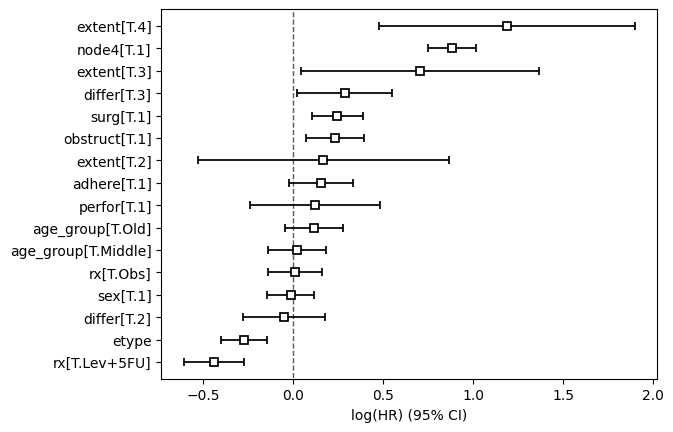

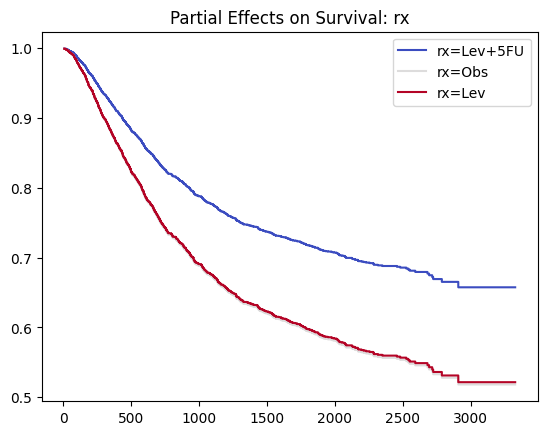

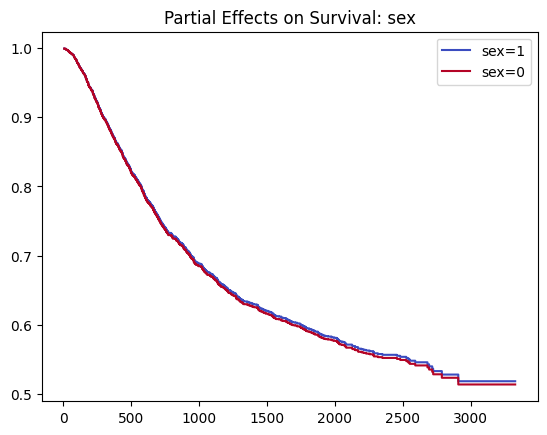

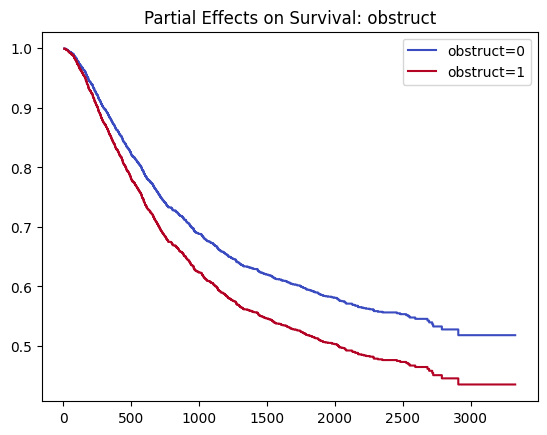

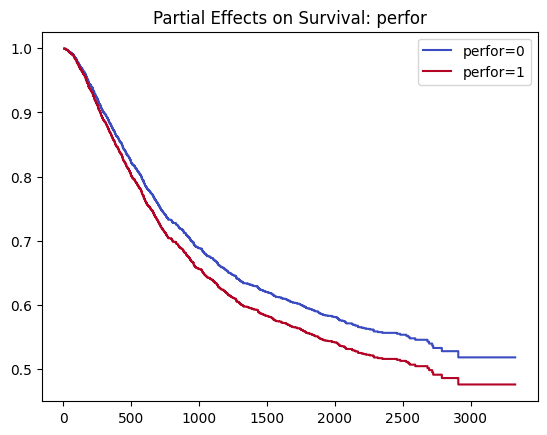

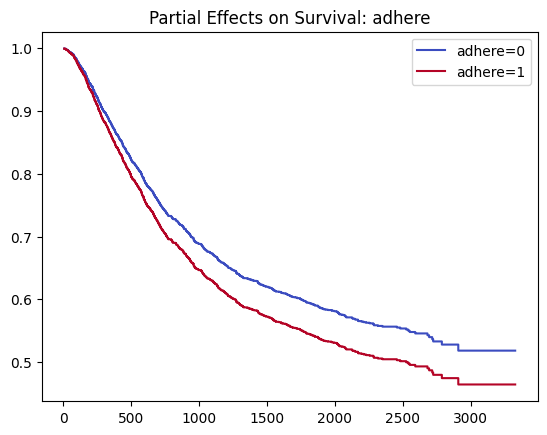

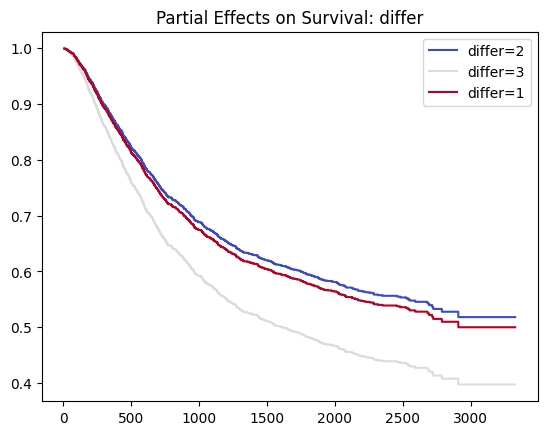

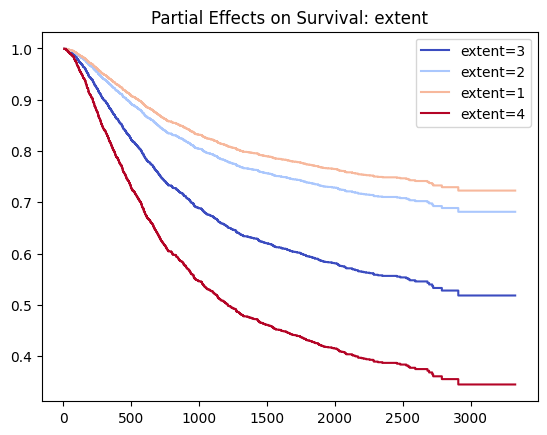

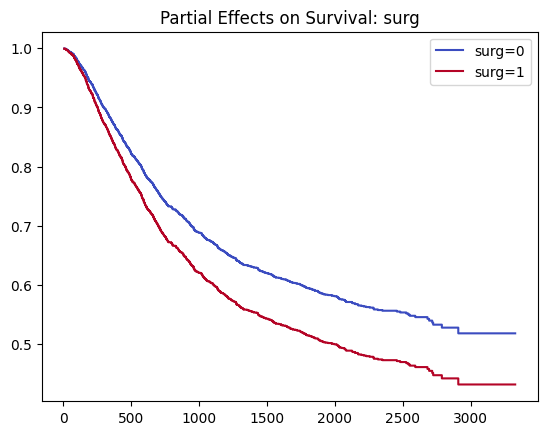

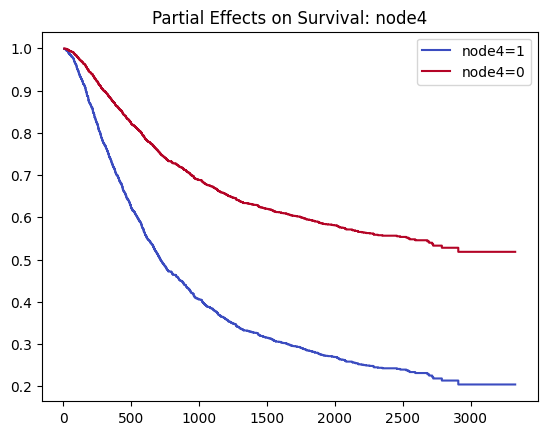

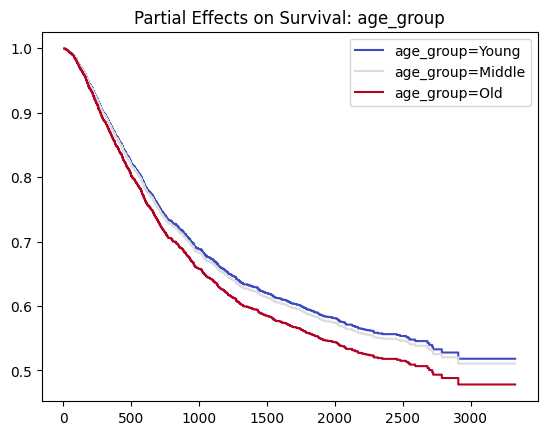

In [11]:
# Plot of the hazard ratios for each covariate

cph_1.plot()


# Plotting survival curves for each covariate
covariates = ['rx', 'sex', 'obstruct', 'perfor', 'adhere', 'differ', 'extent', 'surg', 'node4', 'age_group']

for covariate in covariates:
    unique_values = colon_data_cox[covariate].unique()
    cph.plot_partial_effects_on_outcome(covariate, values=unique_values, plot_baseline=False, cmap='coolwarm')
    plt.title(f'Partial Effects on Survival: {covariate}')
    plt.show()

In [12]:
results = proportional_hazard_test(cph_1, colon_data_cox, time_transform='rank')
results.print_summary()

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1858 total observations, 938 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic      p  -log2(p)
adhere[T.1]                    1.56   0.21      2.24
age_group[T.Middle]            6.93   0.01      6.88
age_group[T.Old]               0.02   0.90      0.15
differ[T.2]                    0.45   0.50      0.99
differ[T.3]                    9.13 <0.005      8.64
etype                        119.90 <0.005     90.28
extent[T.2]                    1.37   0.24      2.05
extent[T.3]                    0.70   0.40      1.31
extent[T.4]                    0.01   0.92      0.13
node4[T.1]                    10.89 <0.005     10.01
obstruct[T.1]                 11.42 <0.005     10.42
perfor[T.1]                    0.32   0.57      0.81
rx[T.Lev+5FU]                  0.32   0.57      0.81
rx[T.Obs]                      0.93   0.34      1.57
sex[T.1]                       3.42   0.06      3.96
surg[T.1]                      0.14   0.71      0.50

#### Model 2 (with only p-values less than or equal to 0.05)

In [13]:
# Updated formula excluding covariates with p-value > 0.05

updated_formula = "rx + obstruct + differ + extent + surg + node4 + etype"

# Fit the updated model
cph_2 = cph.fit(colon_data_cox, duration_col='time', event_col='status', formula=updated_formula, show_progress=True)

# Display the summary of the updated Cox model
cph_2.print_summary()


Iteration 1: norm_delta = 0.63305, step_size = 0.9500, log_lik = -6605.94251, newton_decrement = 159.60620, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.17623, step_size = 0.9500, log_lik = -6462.99556, newton_decrement = 4.97670, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.02982, step_size = 0.9500, log_lik = -6457.94368, newton_decrement = 0.03883, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.00083, step_size = 1.0000, log_lik = -6457.90455, newton_decrement = 0.00001, seconds_since_start = 0.2
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -6457.90454, newton_decrement = 0.00000, seconds_since_start = 0.2
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 1858 total observations, 938 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 1858
number of events observed = 920
   partial log-likelihood = -6457.90
         time fit was run = 2023-11-27 21:24:58 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
rx[T.Lev+5FU]  -0.44       0.64       0.08            -0.61            -0.27                 0.54                 0.76
rx[T.Obs]       0.01       1.01       0.08            -0.15             0.16                 0.86                 1.17
obstruct[T.1]   0.23       1.26       0.08             0.07             0.39                 1.07                 1.47
differ[T.2]    -0.05       0.96       0.12            -0.27             0.18                 0.76                 1.20
differ[T.3]     0.31       1.36       0.13             0.05             0.57                 1.05                 1.77
extent[T.2]     0.21       1.23       0.36            -0.49             0.90                 0.61                 2.47
extent[T.3]     0.75       2.11       0.34             0.08             1.41                 1.09                 4.08
extent[T.4]     1.28       3.59       0.36             0.57             1.98                 1.77                 7.27
surg[T.1]       0.25       1.29       0.07             0.11             0.39                 1.12                 1.48
node4[T.1]      0.87       2.39       0.07             0.74             1.01                 2.09                 2.74
etype          -0.27       0.76       0.07            -0.40            -0.14                 0.67                 0.87

                cmp to     z      p   -log2(p)
covariate                                     
rx[T.Lev+5FU]     0.00 -5.19 <0.005      22.19
rx[T.Obs]         0.00  0.07   0.95       0.08
obstruct[T.1]     0.00  2.83 <0.005       7.74
differ[T.2]       0.00 -0.40   0.69       0.53
differ[T.3]       0.00  2.31   0.02       5.58
extent[T.2]       0.00  0.58   0.56       0.84
extent[T.3]       0.00  2.21   0.03       5.21
extent[T.4]       0.00  3.55 <0.005      11.32
surg[T.1]         0.00  3.48 <0.005      10.94
node4[T.1]        0.00 12.68 <0.005     120.00
etype             0.00 -4.15 <0.005      14.85
---
Concordance = 0.67
Partial AIC = 12937.81
log-likelihood ratio test = 296.08 on 11 df
-log2(p) of ll-ratio test = 186.80

#### Model 3

Concordance score became lower than with all the covariates. Trying with interaction now:

In [14]:
interaction_formula = "rx + obstruct + differ + extent + surg + node4 + etype + rx:node4 + rx:obstruct + rx:surg"

# Fit the model with interaction terms
cph_interaction = CoxPHFitter(baseline_estimation_method='breslow')
cph_interaction.fit(colon_data_cox, duration_col='time', event_col='status', formula=interaction_formula, show_progress=True)

# Display the summary
cph_interaction.print_summary()

Iteration 1: norm_delta = 0.80099, step_size = 0.9500, log_lik = -6605.94251, newton_decrement = 167.10342, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.25809, step_size = 0.9500, log_lik = -6462.37420, newton_decrement = 9.30093, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.03079, step_size = 0.9500, log_lik = -6452.98973, newton_decrement = 0.05815, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.00059, step_size = 1.0000, log_lik = -6452.93131, newton_decrement = 0.00001, seconds_since_start = 0.2
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -6452.93131, newton_decrement = 0.00000, seconds_since_start = 0.2
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 1858 total observations, 938 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 1858
number of events observed = 920
   partial log-likelihood = -6452.93
         time fit was run = 2023-11-27 21:24:59 UTC

---
                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                           
rx[T.Lev+5FU]                -0.35       0.70       0.14            -0.62            -0.09                 0.54                 0.92
rx[T.Obs]                     0.23       1.26       0.12            -0.00             0.47                 1.00                 1.60
obstruct[T.1]                 0.52       1.68       0.13             0.26             0.78                 1.29                 2.18
differ[T.2]                  -0.05       0.95       0.12            -0.28             0.17                 0.75                 1.19
differ[T.3]                   0.30       1.35       0.13             0.04             0.56                 1.04                 1.76
extent[T.2]                   0.23       1.26       0.36            -0.47             0.93                 0.63                 2.52
extent[T.3]                   0.76       2.14       0.34             0.10             1.42                 1.11                 4.16
extent[T.4]                   1.26       3.54       0.36             0.56             1.97                 1.74                 7.18
surg[T.1]                     0.32       1.38       0.12             0.08             0.56                 1.08                 1.75
node4[T.1]                    0.98       2.65       0.12             0.75             1.20                 2.11                 3.33
etype                        -0.28       0.76       0.07            -0.41            -0.15                 0.67                 0.86
rx[T.Lev+5FU]:node4[T.1]     -0.04       0.96       0.18            -0.38             0.31                 0.68                 1.36
rx[T.Obs]:node4[T.1]         -0.18       0.84       0.16            -0.49             0.14                 0.61                 1.15
rx[T.Lev+5FU]:obstruct[T.1]  -0.43       0.65       0.21            -0.85            -0.02                 0.43                 0.98
rx[T.Obs]:obstruct[T.1]      -0.44       0.65       0.19            -0.80            -0.07                 0.45                 0.93
rx[T.Lev+5FU]:surg[T.1]       0.05       1.05       0.19            -0.32             0.42                 0.73                 1.52
rx[T.Obs]:surg[T.1]          -0.20       0.82       0.17            -0.53             0.13                 0.59                 1.14

                              cmp to     z      p   -log2(p)
covariate                                                   
rx[T.Lev+5FU]                   0.00 -2.60   0.01       6.73
rx[T.Obs]                       0.00  1.94   0.05       4.26
obstruct[T.1]                   0.00  3.89 <0.005      13.29
differ[T.2]                     0.00 -0.46   0.64       0.64
differ[T.3]                     0.00  2.23   0.03       5.27
extent[T.2]                     0.00  0.64   0.52       0.94
extent[T.3]                     0.00  2.26   0.02       5.39
extent[T.4]                     0.00  3.50 <0.005      11.06
surg[T.1]                       0.00  2.62   0.01       6.85
node4[T.1]                      0.00  8.41 <0.005      54.45
etype                           0.00 -4.20 <0.005      15.18
rx[T.Lev+5FU]:node4[T.1]        0.00 -0.21   0.83       0.26
rx[T.Obs]:node4[T.1]            0.00 -1.10   0.27       1.87
rx[T.Lev+5FU]:obstruct[T.1]     0.00 -2.03   0.04       4.58
rx[T.Obs]:obstruct[T.1]         0.00 -2.33   0.02       5.66
rx[T.Lev+5FU]:surg[T.1]         0.00  0.27   0.78       0.35
rx[T.Obs]:sur

The concordance for model 3 stayed the same as in model 2, which is the least complex model. The most accurate model is model 1, but since the difference in concordance is 0.01, I would argue it is better to use model 2 which is less complex and offers nearly as good results as model 1.

#### Q3: What is the interpretation of your best-performing CoxPH model? Provide a brief summary (approx. 100 - 150 words). Address the statistical significance of covariates/features and hazard ratios 

The Cox Proportional Hazards (CoxPH) model provides valuable insights into the factors significantly impacting patient survival in the colon cancer study. The most effective model, selected based on its concordance score and complexity, analyzed 1858 observations, witnessing 920 events. Notably, the presence of more than four lymph nodes (node4) emerged as a critical factor, with a hazard ratio (HR) of 2.39. This indicates that patients with more than four lymph nodes have a substantially higher risk of an event occuring compared to those with fewer nodes. Another critical factor can be found in the extent covariate, indicating that patients with extensive spread of tumor have higher risks (HR = 1.23, 2.11 and 3.59). Additionally, the treatment category 'Lev + 5FU' shows a significant impact on survival, with an HR of 0.64. This lower HR suggests a reduced risk for patients receiving this treatment, highlighting its effectiveness. All these covariates demonstrate high statistical significance, with p-values below 0.005, underscoring their pivotal roles in determining patient survival outcomes.

#### Q4: How do the results from your best-performing CoxPH model correspond to the results acquired from the KM curves in Task 1?

The results from the best-performing Cox Proportional Hazards (CoxPH) model align closely with the observations made in the Kaplan-Meier (KM) curves from Task 1. Both analyses underscore the significance of certain covariates, particularly the treatment type, extent of the disease, and the presence of more than four lymph nodes (node4). In the KM curves, we observed notable differences in survival probabilities based on these factors, which is consistent with the CoxPH model's findings where these variables showed significant hazard ratios. This congruence between the KM analysis and the CoxPH model reinforces the interpretation that treatment type, extent of disease, and the number of lymph nodes are critical determinants of survival outcomes in patients with colon cancer. The consistency across these distinct statistical methods lends robustness to our conclusions about the factors influencing patient survival.

### Task 3


nodes    36
dtype: int64
      Unnamed: 0   id  study       rx sex  age obstruct perfor adhere  nodes  \
186          187   94      1  Lev+5FU   0   26        0      0      1    NaN   
187          188   94      1  Lev+5FU   0   26        0      0      1    NaN   
196          197   99      1      Lev   1   71        0      0      1    NaN   
197          198   99      1      Lev   1   71        0      0      1    NaN   
284          285  143      1  Lev+5FU   0   49        0      0      0    NaN   
285          286  143      1  Lev+5FU   0   49        0      0      0    NaN   
376          377  189      1      Lev   1   72        0      0      0    NaN   
377          378  189      1      Lev   1   72        0      0      0    NaN   
396          397  199      1  Lev+5FU   0   32        0      0      0    NaN   
397          398  199      1  Lev+5FU   0   32        0      0      0    NaN   
674          675  338      1      Lev   1   58        0      0      0    NaN   
675          67

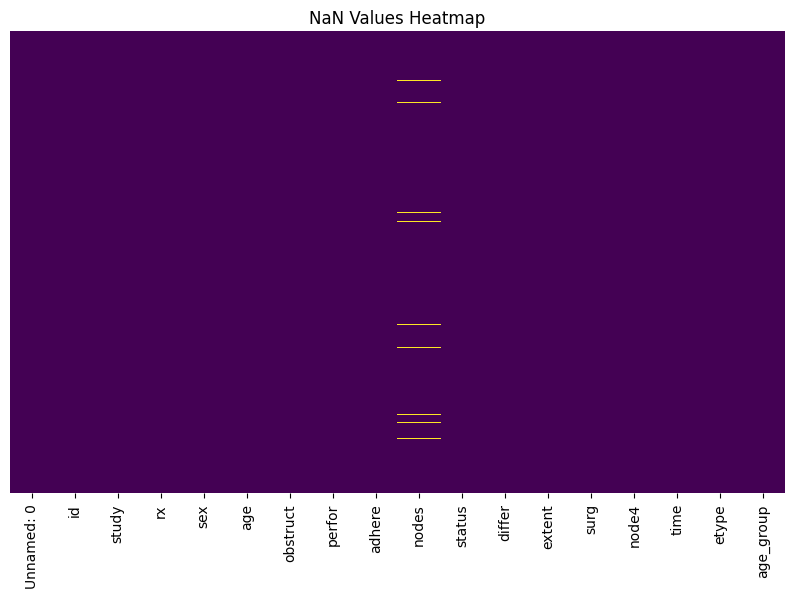

In [15]:
# Check for NaN values in each column
nan_counts = colon_data.isna().sum()

# Display columns with NaN counts greater than 0
nan_columns = nan_counts[nan_counts > 0]
print(nan_columns)

rows_with_nan = colon_data[colon_data.isna().any(axis=1)]

print(rows_with_nan)

# Generate a heatmap to visualize the NaN values in the dataset
plt.figure(figsize=(10, 6))
sns.heatmap(colon_data.isna(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('NaN Values Heatmap')
plt.show()

All the NaN values are from the nodes. There are only 36 NaN values, which is not a lot when looking at the dataset as a whole. Therefore one can either plainly remove them, or impute them by the mean or median. I chose to do the median as seen below.

In [16]:
# Median imputation for 'nodes' column
colon_data['nodes'].fillna(colon_data['nodes'].median(), inplace=True)

# Convert the 'status' column to boolean
colon_data['status'] = colon_data['status'].astype(bool)

# One-hot encoding for the 'rx' column with boolean values
rx_dummies = pd.get_dummies(colon_data['rx'], prefix='rx').astype(bool)

# Concatenate the dummy variables with the original DataFrame
colon_data = pd.concat([colon_data, rx_dummies], axis=1)

# Drop the original 'rx' column and any other unnecessary columns
colon_data.drop(['rx', 'study', 'age', 'age_group'], axis=1, inplace=True)

# Display the first few rows of the updated DataFrame
print(colon_data.head(3))


colon_data["etype"] = np.where(colon_data["etype"] == 2, True, False)
colon_data = colon_data[colon_data["etype"]].drop("etype", axis=1)
colon_data["time"] = colon_data["time"].astype(int)

colon_data.reset_index(inplace=True, drop=True)

selected_cols = ['sex',
 'obstruct',
 'rx_Lev',
 'rx_Lev+5FU',
 'perfor',
 'adhere',
 'differ',
 'extent',
 'surg',
 'node4']

y_df = colon_data[["status", "time"]].copy()
y = colon_data[["status", "time"]].to_records(index=False)
X = colon_data[selected_cols].copy()
stratify_y = [label for label, _ in y]


   Unnamed: 0  id sex obstruct perfor adhere  nodes  status differ extent  \
0           1   1   1        0      0      0    5.0    True      2      3   
1           2   1   1        0      0      0    5.0    True      2      3   
2           3   2   1        0      0      0    1.0   False      2      3   

  surg node4  time  etype  rx_Lev  rx_Lev+5FU  rx_Obs  
0    0     1  1521      2   False        True   False  
1    0     1   968      1   False        True   False  
2    0     0  3087      2   False        True   False  


In [17]:
colon_data.head(3)

,Unnamed: 0,id,sex,obstruct,perfor,adhere,nodes,status,differ,extent,surg,node4,time,rx_Lev,rx_Lev+5FU,rx_Obs
0,1,1,1,0,0,0,5.0,True,2,3,0,1,1521,False,True,False
1,3,2,1,0,0,0,1.0,False,2,3,0,0,3087,False,True,False
2,5,3,0,0,0,1,7.0,True,2,2,0,1,963,False,False,True


In [25]:
print(X.shape)
print(y.shape)

(929, 10)
(929,)


In [18]:
def concordance_index(y_true, y_pred):
    c_index = concordance_index_censored(y_true["status"], y_true["time"], y_pred)[0]
    return c_index

concordance_score = make_scorer(concordance_index, greater_is_better=True)    

## Cox PH

In [19]:
cox_params = {'alpha': [0.01, 0.1, 1, 10, 100]}

cv = StratifiedKFold(n_splits=4)

cox_model = CoxPHSurvivalAnalysis()
cox_results = {
    'concordance': [],
    'IBS': [],
    'permutation': []
}

important_feats = []

cox_grid_search = GridSearchCV(cox_model,
                               cox_params,
                               n_jobs=-1, 
                               scoring=concordance_score,
                               error_score='raise')

for train, test in cv.split(X, stratify_y):
    X_train, X_test = X.iloc[train], X.iloc[test]
    _, y_test = y_df.iloc[train], y_df.iloc[test]
    y_train, _  = y[train], y[test]


    max_time  = y_train["time"].max()
    x_domain_train = np.arange(0, max_time, 1)

    indices = y_test["time"] <= max_time
    X_test = X_test[indices]
    y_test = y_test[indices]

    x_domain_test = np.arange(y_test["time"].min()+3,
                              y_test["time"].max()+3,
                              1)

    cox_grid_search.fit(X_train, y_train)

    pred = cox_grid_search.best_estimator_.predict(X_test)
    cox_results['concordance'].append(concordance_index(y_test,
                                                              pred))

    print(x_domain_test)

    survival_pred = cox_grid_search.best_estimator_.predict_survival_function(X_test)
    survival_pred = np.asarray(
        [[fn(t) for t in x_domain_test] 
         for fn in survival_pred])
    cox_results["IBS"].append(integrated_brier_score(y_train,
                                                     y_test.to_records(index=False),
                                                     survival_pred,
                                                     x_domain_test-3))
    
    cox_importance = permutation_importance(cox_grid_search.best_estimator_,
                                            X_test,
                                            y_test.to_records(index=False),
                                            n_repeats=10,
                                            random_state=23)
    cox_results["permutation"].append(np.mean(cox_importance.importances_mean))
    important_feats.append(cox_importance)

[  26   27   28 ... 2913 2914 2915]
[  55   56   57 ... 2915 2916 2917]
[  27   28   29 ... 2668 2669 2670]
[  59   60   61 ... 2422 2423 2424]


In [20]:
print("Model: CoxPHSurvivalAnalysis()")
for key, value in cox_results.items():
    print(f"{key}: {round(np.mean(value), 3)} +- {round(np.std(value), 3)}")

Model: CoxPHSurvivalAnalysis()
concordance: 0.652 +- 0.012
IBS: 0.284 +- 0.194
permutation: 0.015 +- 0.003


In [21]:
mean_importance = np.mean([feats.importances_mean for feats in important_feats], axis = 0)

sorted_inx = mean_importance.argsort()

for i, j in zip(X.columns[sorted_inx], mean_importance[sorted_inx]):
    print(f"{i}: {j}")

rx_Lev: -0.0009941821003634998
sex: -0.0006463658839716808
perfor: -0.0006132582796847251
adhere: 0.0026005126413977623
obstruct: 0.00521275198332124
surg: 0.006167536079756734
differ: 0.00638576447603254
rx_Lev+5FU: 0.011470495210922301
extent: 0.025017733007861385
node4: 0.09452852638016078


## Random Forest

In [22]:
forest_params = {
    'n_estimators': [5, 10, 20, 30, 40, 50],
    'max_depth': [1, 2, 4, 6, 10]}

forest_cv = StratifiedKFold(n_splits=4)

forest= RandomSurvivalForest()
forest_results = {
    'concordance': [],
    'IBS': [],
    'permutation': []
}

important_features = []

forest_grid_search = GridSearchCV(forest,
                               forest_params,
                               n_jobs=-1, 
                               scoring=concordance_score,
                               error_score='raise')

for train, test in forest_cv.split(X, stratify_y):
    X_train, X_test = X.iloc[train], X.iloc[test]
    _, y_test = y_df.iloc[train], y_df.iloc[test]
    y_train, _  = y[train], y[test]


    max_time  = y_train["time"].max()
    x_domain_train = np.arange(0, max_time, 1)

    indeces = y_test["time"] <= max_time
    X_test = X_test[indeces]
    y_test = y_test[indeces]

    x_domain_test = np.arange(y_test["time"].min()+1,
                              y_test["time"].max(),
                              1)

    print(max_time)

    forest_grid_search.fit(X_train, y_train)

    pred = forest_grid_search.best_estimator_.predict(X_test)
    forest_results['concordance'].append(concordance_index(y_test,
                                                              pred))

    survival_pred = forest_grid_search.best_estimator_.predict_survival_function(X_test)
    survival_pred = np.asarray(
        [[fn(t) for t in x_domain_test] 
         for fn in survival_pred])
    forest_results["IBS"].append(integrated_brier_score(y_train,
                                                     y_test.to_records(index=False),
                                                     survival_pred,
                                                     x_domain_test))
    
    rf_importance = permutation_importance(forest_grid_search.best_estimator_,
                                            X_test,
                                            y_test.to_records(index=False),
                                            n_repeats=10,
                                            random_state=23)
    forest_results["permutation"].append(np.mean(rf_importance.importances_mean))
    important_features.append(rf_importance)

2915
3329
3329
3329


In [23]:
print("Model: RandomSurvivalForest()")
for key, value in forest_results.items():
    print(f"{key}: {round(np.mean(value), 3)} +- {round(np.std(value), 3)}")

Model: RandomSurvivalForest()
concordance: 0.646 +- 0.02
IBS: 0.303 +- 0.215
permutation: 0.015 +- 0.004


In [24]:
mean_importance = np.mean([feats.importances_mean for feats in important_features], axis = 0)

sorted_inx = mean_importance.argsort()

for i, j in zip(X.columns[sorted_inx], mean_importance[sorted_inx]):
    print(f"{i}: {j}")

rx_Lev: -0.0010933420364125923
perfor: -0.00027704894537246283
sex: 0.00021993003395411048
obstruct: 0.0031440768491086627
surg: 0.005116169684783056
adhere: 0.005794241649803883
rx_Lev+5FU: 0.009609694480201193
differ: 0.016739584736939837
extent: 0.017593771289238305
node4: 0.093984112468802


#### Q5: What is the interpretation of your best performing models (CoxPhSurvivalAnalysis and RandomSurvivalForest)? Provide a brief summary

In my analysis, the Cox Proportional Hazards (CoxPHSurvivalAnalysis) and Random Survival Forest (RandomSurvivalForest) models exhibited concordance scores of 0.652 and 0.646, respectively. These scores are slightly lower than the 0.67 concordance score observed in the earlier Cox model from Task 2, indicating a marginal difference in predictive accuracy. In terms of the Integrated Brier Score, which measures the accuracy of predicted survival probabilities, the Cox model scored 0.284, while the Random Survival Forest model scored 0.303. The variability in these scores is highlighted by their standard deviations, approximately ±0.194 for Cox and ±0.215 for Random Survival Forest. A key observation from the feature importance analysis is the consistent emphasis on node4 (the presence of more than four lymph nodes), extent of disease spread, and the 'rx_Lev+5FU' treatment category as significant factors in both models. This consistency across different modeling approaches underscores the critical role these features play in influencing survival outcomes in colon cancer patients.

#### Q6: How do the results from the best-performing models (each algorithms) compare to the results in Task 1 and Task 2? Address the feature importance in comparison to the tests of statistical significance of covariates/features in Task 1 and Task2.

In comparing the results from my best-performing CoxPHSurvivalAnalysis and RandomSurvivalForest models to the findings in Task 1 and Task 2, several key parallels and differences emerge. Notably, both the Kaplan-Meier analysis in Task 1 and the CoxPH model in Task 2 highlighted the significance of certain covariates such as treatment type, obstruction, extent and node4 presence, which were found to have substantial impacts on survival outcomes. These insights are largely corroborated by the feature importance results from our best-performing models in the current task.

Earlier for task 3 I tried implementing the code I had below but no matter what I did, it still contained either NaN or infinite values. Therefore I got help from some classmates to complete task 3. 

In [ ]:
"""
# Custom scoring function for concordance index
def custom_concordance_index(y_true, y_pred):
    return concordance_index_censored(y_true["status"], y_true["time"], y_pred)[0]

conc_scorer = make_scorer(custom_concordance_index, greater_is_better=True)

# Hyperparameter grids
param_grid_cox = {'alpha': [0.01, 0.1, 1, 10, 100]}
param_grid_rf = {'n_estimators': [5, 10, 20, 30, 40, 50], 'max_depth': [2, 4, 6, 8, 10]}

# Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5)

# Initialize models
cox_model = CoxPHSurvivalAnalysis()
rf_model = RandomSurvivalForest()

# Initialize result dictionaries
cox_results = {'concordance': [], 'IBS': [], 'permutation': []}
rf_results = {'concordance': [], 'IBS': [], 'permutation': []}

# CoxPH Model Training and Evaluation
cox_grid_search = GridSearchCV(cox_model, param_grid_cox, scoring=conc_scorer, cv=cv, n_jobs=-1, error_score='raise')
cox_grid_search.fit(X, y)
best_cox_model = cox_grid_search.best_estimator_

# Random Survival Forest Training and Evaluation
rf_grid_search = GridSearchCV(rf_model, param_grid_rf, scoring=conc_scorer, cv=cv, n_jobs=-1, error_score='raise')
rf_grid_search.fit(X, y)
best_rf_model = rf_grid_search.best_estimator_

# Perform evaluation for both models
for model, results, best_estimator in zip(
        [cox_model, rf_model],
        [cox_results, rf_results],
        [best_cox_model, best_rf_model]):
    
    for train, test in cv.split(X, colon_data['status']):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y[train], y[test]

        # Predictions and evaluations
        pred = best_estimator.predict(X_test)
        results['concordance'].append(custom_concordance_index(y_test, pred))
        
        # Integrated Brier Score
        survival_pred = best_estimator.predict_survival_function(X_test)
        survival_pred = np.asarray([[fn(t) for t in np.arange(y_test['time'].min(), y_test['time'].max())] for fn in survival_pred])
        results["IBS"].append(integrated_brier_score(y_train, y_test, survival_pred, np.arange(y_test['time'].min(), y_test['time'].max())))
        
        # Permutation Feature Importance
        perm_importance = permutation_importance(best_estimator, X_test, y_test, n_repeats=10, random_state=0)
        results["permutation"].append(np.mean(perm_importance.importances_mean))

# Print results
for model_name, model_results in zip(['CoxPHSurvivalAnalysis', 'RandomSurvivalForest'], [cox_results, rf_results]):
    print(f"Model: {model_name}")
    for key, value in model_results.items():
        print(f"{key}: {np.mean(value):.3f} ± {np.std(value):.3f}")
"""